In [8]:
!git clone -b mittra https://github.com/tirthankar95/CSCI_7000_FinalProject.git
!sudo apt install rar

Cloning into 'CSCI_7000_FinalProject'...
remote: Enumerating objects: 619, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 619 (delta 59), reused 117 (delta 44), pack-reused 477
Receiving objects: 100% (619/619), 24.86 MiB | 11.89 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
rar is already the newest version (2:5.5.0-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [9]:
import tensorflow as tf 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
%cd /content/CSCI_7000_FinalProject/gym-minigrid/

/content/CSCI_7000_FinalProject/gym-minigrid


In [11]:
from HandCraftedEnv.mylava_env import *

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed,SimpleRNN,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
import re

In [13]:
def plotProgress(reward_plot,xlabel,ylabel,title):
    plt.plot(reward_plot)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(f'{ylabel}_lava.png')
    plt.show()

def create():
    global num_actions,frameForPrediction
    input=Input(shape=(frameForPrediction,25)) # (4,1,5,5) ~ my grid returns (1,2*visibility+1,2*visibility+1)
    temp=LSTM(units=100,return_sequences=False)(input)
    temp=Dense(units=100, activation='relu')(temp)
    temp=Dense(units=50, activation='relu')(temp)
    temp=Dense(units=10, activation='relu')(temp)
    output=Dense(units=num_actions,activation='linear')(temp)
    model=Model(input,output)
    return model

In [14]:
def trainAgentInEnv():
  global model,model_target,loss_function,optimizer,reward_plot,action_history,state_history,state_next_history,rewards_history,noOfUpdates
  # Configuration paramaters for the whole setup
  seed = 42
  gamma = 0.99  # Discount factor for past rewards
  epsilon = 1.0  # Epsilon greedy parameter
  epsilon_min = 0.1  # Minimum epsilon greedy parameter
  epsilon_max = 1.0  # Maximum epsilon greedy parameter
  epsilon_interval = (
      epsilon_max - epsilon_min
  )  # Rate at which to reduce chance of random action being taken
  batch_size = 128  # Size of batch taken from replay buffer
  max_steps_per_episode = 1000
  episode_reward_history=[]

  running_reward = 0
  frame_count = 0
  # Number of frames to take random action and observe output
  epsilon_random_frames = 10000
  # Number of frames for exploration
  epsilon_greedy_frames = 1000000.0
  # Maximum replay length
  # Note: The Deepmind paper suggests 1000000 however this causes memory issues
  max_memory_length = 100000
  # Train the model after 4 actions
  update_after_actions = 10
  # How often to update the target network
  update_target_network = 10000
  # Using huber loss for stability
  # We are taking 4 frames in our LSTM
  frame_offset=frameForPrediction-1
  noOfEpisodes=1000 #beast 100000

  dummy_state=[[[-1 for i in range(5)] for j in range(5)]] #2*visibility+1=5
  dummy_action=-1
  dummy_reward=-1
  dummy=-1
  # Run this multiple times. (1000)
  state, reward, done, _ = env.reset_m()
  for _ in tqdm(range(noOfEpisodes)):  # Run until solved
      state, reward, done, _ = env.reset_prev()
      episode_reward = 0
      for i in range(frame_offset):
        state_history.append(dummy_state)
        state_next_history.append(dummy_state)
        rewards_history.append(dummy_reward)
        action_history.append(dummy_action)
        done_history.append(dummy)
      for timestep in range(1, max_steps_per_episode):
          # env.render(); Adding this line would show the attempts
          # of the agent in a pop up window.
          frame_count += 1
          # Use epsilon-greedy for exploration
          if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
              # Take random action
              action = np.random.choice(num_actions)
          else:
              # Predict action Q-values
              # From environment state
              state_numpy = np.array(state_history[-frameForPrediction:]).reshape(frameForPrediction,25)
              state_numpy = np.array([state_numpy])
              action_probs = model(state_numpy, training=False)
              # Take best action
              action = np.argmax(action_probs[0])

          # Decay probability of taking random action
          epsilon -= epsilon_interval / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min)

          # Apply the sampled action in our environment
          state_next, reward, done, _ = env.step_m(action)
          episode_reward += reward

          # Save actions and states in replay buffer
          state_history.append(state)
          state_next_history.append(state_next)
          action_history.append(action)
          done_history.append(done)
          rewards_history.append(reward)
          state = state_next

          # Update every fourth frame and once batch size is over 32
          if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
              # Get indices of samples for replay buffers
              noOfUpdates-=1
              if noOfUpdates==0:
                indices = np.random.choice(range(len(done_history)-frame_offset), size=len(done_history))+frame_offset
                noOfUpdates=20000
              else:
                indices = np.random.choice(range(len(done_history)-frame_offset), size=batch_size)+frame_offset
              # Using list comprehension to sample from replay buffer
              state_sample = np.array([ np.array(state_history[i-frame_offset:i+1]).reshape(frameForPrediction,25) for i in indices])
              state_next_sample = np.array([ np.array(state_next_history[i-frame_offset:i+1]).reshape(frameForPrediction,25) for i in indices])
              rewards_sample = [rewards_history[i] for i in indices]
              action_sample = [action_history[i] for i in indices]
              # Build the updated Q-values for the sampled future states
              # Use the target model for stability
              future_rewards = model_target.predict(state_next_sample,verbose=False)
              # Q value = reward + discount factor * expected future reward
              updated_q_values = rewards_sample + gamma * np.max(future_rewards, axis=1)
              updated_q_values = updated_q_values.astype('float32')
              # Create a mask so we only calculate loss on the updated Q-values
              masks = tf.one_hot(action_sample, num_actions)
              with tf.GradientTape() as tape:    
                  q_values = model(state_sample)
                  # Apply the masks to the Q-values to get the Q-value for action taken
                  q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                  loss = loss_function(updated_q_values,q_action)
              # Backpropagation
              grads = tape.gradient(loss, model.trainable_variables)
              optimizer.apply_gradients(zip(grads, model.trainable_variables))
              

          if frame_count % update_target_network == 0:
              # update the the target network with new weights
              model_target.set_weights(model.get_weights())
              # Log details
              template = "running reward: {:.2f} at episode {}, frame count {}"
              print(template.format(running_reward, _, frame_count))

          # Limit the state and reward history
          if len(rewards_history) > max_memory_length:
              del rewards_history[:1]
              del state_history[:1]
              del state_next_history[:1]
              del action_history[:1]
              del done_history[:1]
          if done:
              break
      # Update running reward to check condition for solving
      episode_reward_history.append(episode_reward)
      running_reward = np.mean(episode_reward_history)
      reward_plot.append(episode_reward)
      episode_steps_plot.append(timestep)

In [15]:
num_actions=5
frameForPrediction=4
noOfUpdates=20000 #after 20000 frames do a full

action_history = []
state_history = []
state_next_history = []
rewards_history = []
reward_plot = []
episode_steps_plot = []
done_history = []

env = lava(difficulty=20)
model=create()
model_target=create()

loss_function = keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.RMSprop()

100%|██████████| 1000/1000 [01:11<00:00, 13.91it/s]


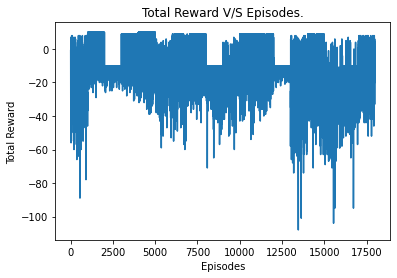

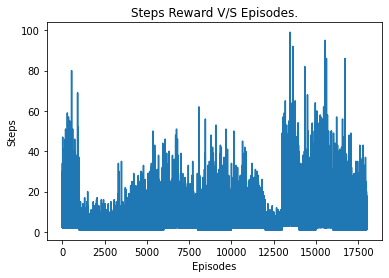


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Updating archive Expert_l.ml.rar

Updating  Expert_l.ml/saved_model.pb                                      72%  OK 
Updating  Expert_l.ml/variables/variables.data-00000-of-00001             97%  OK 
Updating  Expert_l.ml/variables/variables.index                           97%  OK 
Updating  Expert_l.ml/keras_metadata.pb                                   99%  OK 
Updating  Expert_l.ml/variables                                            OK 
Updating  Expert_l.ml/assets                                               OK 
Done


In [52]:
def loadCheckPoints():
  global model,model_target,reward_plot,episode_steps_plot 
  model.load_weights('Expert_l.ml')
  file=open('RewardsL.txt','r')
  reward_plot=[ int(i) for i in re.split(',|\[|\]',file.read()) if i!='' ]
  file.close()
  file=open('EpisodesL.txt','r')
  episode_steps_plot=[ int(i) for i in re.split(',|\[|\]',file.read()) if i!='' ]
  file.close()

def saveCheckPoints():
  # Save checkpoints. 
  file=open('RewardsL.txt','w')
  file.write(str(reward_plot))
  file.close()
  file=open('EpisodesL.txt','w')
  file.write(str(episode_steps_plot))
  file.close()
  model.save('Expert_l.ml')
  plotProgress(reward_plot,'Episodes','Total Reward','Total Reward V/S Episodes.')
  print()
  plotProgress(episode_steps_plot,'Episodes','Steps','Steps Reward V/S Episodes.')


#Use for loop later on but for now call manually
trainAgentInEnv()
# for gce.
saveCheckPoints()
!rar -r a Expert_l.ml.rar Expert_l.ml/
loadCheckPoints()

In [ ]:
# For normal collab.
from google.colab import drive,files
drive.mount("/content/drive")
!cp -rf Expert_dk.ml /content/drive/MyDrive/SavedRLModels/

In [53]:
state, reward, done, _ = env.reset_prev()
frame_offset=frameForPrediction-1

state_historyP=[ state for i in range(frameForPrediction)]

while not done:
  state_numpyP = np.array(state_historyP[-frameForPrediction:]).reshape(frameForPrediction,25)
  state_numpyP = np.array([state_numpyP])
  action_probs = model(state_numpyP, training=False)
  action = np.argmax(action_probs[0])
  env.printEnv()
  print(action)
  state, reward, done, _ = env.step_m(action)
  del state_historyP[:1]
  state_historyP.append(state)



0 4 0 0 
0 8 0 32 
0 0 0 8 
0 0 8 8 



1


0 0 4 0 
0 8 0 32 
0 0 0 8 
0 0 8 8 



1


0 0 0 4 
0 8 0 32 
0 0 0 8 
0 0 8 8 



3
